## Thu thập dữ liệu gồm OHLC data và corporate action data
- Quá khứ đến 1.10.2025
- Tất cả nếu lấy sau ngày 1.10 thì tuyệt đối không đụng đến để đoạn từ 1.10 đến
31.12 sẽ bung ra sau (giả thực tế)
## Xử lý dữ liệu
- Stock Split
- Dividends
- Missing values & outliers
## Technical Indicators and Build Signal
- Stock Return (Log Returns)
- Build Momentum Signal (tín hiệu có thể là vị trí của giá so với Simple Moving Average (SMA)
hoặc Bollinger Bands)
## Cross-sectional
- Ranking
- Long/Short Position (Mua/Bán n cổ phiếu có thứ hạng cao đến thấp/thấp đến cao, Equal Weighting)
- Rebalancing (Giữ danh mục đầu tư này trong 1 tháng. Vào cuối tháng, đóng tất cả các vị thế, tính toán lại signal,
ranking lại, và mở các vị thế long/short mới cho tháng tiếp theo.)
## Backtesting
- Tính lợi nhuận hàng tháng của danh mục. Lợi nhuận của danh mục là trung bình của lợi nhuận từ các vị thế long và short.
- Statistical Analysis (Hypothesis Testing, "Alpha" - lợi nhuận vượt trội so với thị trường chuẩn, sử dụng QQ Plot để kiểm tra xem nó có "đuôi béo" (fat tails) hay không - cho thấy rủi ro cao hơn so với phân phối chuẩn.)
- Regression (tránh Bias)

### Lưu ý
- Lúc làm data lấy từ 1.2015 đến 31.9.2025
- Pick random 80:20/ 70:30
- 6 tháng / 3 tháng
- 6.2016 - 12.2016, 1.2018-6.2018, 3.2021-12.2021


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

Bắt đầu thực hiện chiến lược Momentum Bền Vững (HÀNG NGÀY, 2015 - 2025)...
Giai đoạn 1: Đang tải và xử lý dữ liệu...


C:\Users\Tam Nguyen\AppData\Local\Temp\ipykernel_7532\2720053030.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download(all_tickers, start=start_str, end=end_str)
[*********************100%***********************]  13 of 13 completed


Tải dữ liệu thành công. Sử dụng cột 'Close' (đã điều chỉnh).
Đang xử lý missing values (ffill)...
Giai đoạn 2: Đang tính toán tín hiệu Momentum (SMA 20/50) HÀNG NGÀY...
Giai đoạn 3: Đang xây dựng danh mục (Long/Short) HÀNG NGÀY...
Giai đoạn 4: Đang thực hiện Backtesting HÀNG NGÀY...

Giai đoạn 5: Đang tính toán Alpha...

--- KẾT QUẢ HỒI QUY (REGRESSION RESULTS) ---
Alpha Hàng ngày (Hệ số chặn β₀): 0.000125
Beta (Hệ số β₁ vs QQQ):           0.0589
R-squared (Mức độ giải thích):   0.0365
----------------------------------------
ALPHA HÀNG NĂM (ĐÃ CHUẨN HÓA): 0.0315 (3.15%)



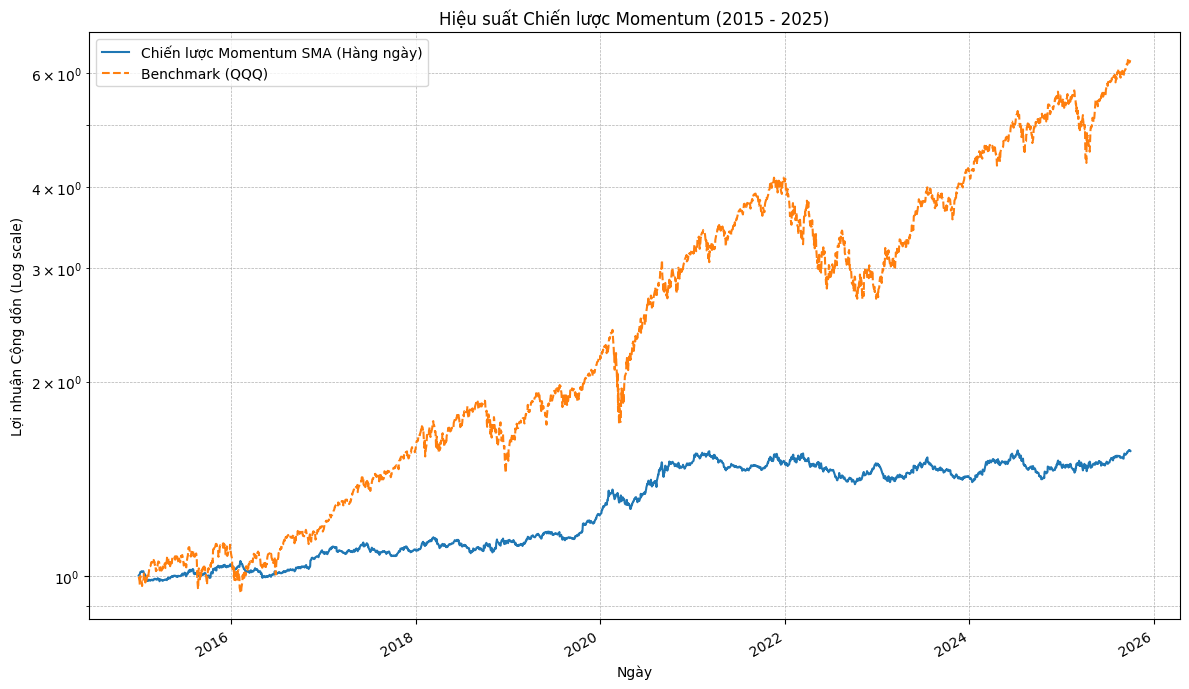

In [32]:
print("Bắt đầu thực hiện chiến lược Momentum Bền Vững (HÀNG NGÀY, 2015 - 2025)...")

# GIAI ĐOẠN 1: THU THẬP VÀ XỬ LÝ DỮ LIỆU
# -------------------------------------------------
print("Giai đoạn 1: Đang tải và xử lý dữ liệu...")

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'JPM', 'JNJ', 'XOM', 'PG', 'NVDA', 'V', 'TSLA', 'WMT']
benchmark = 'QQQ'
all_tickers = tickers + [benchmark]

start_str = '2014-10-01'
end_str = '2025-09-30'

data = None
data_raw = None

try:
    data_raw = yf.download(all_tickers, start=start_str, end=end_str)
    data = data_raw['Close']
    print("Tải dữ liệu thành công. Sử dụng cột 'Close' (đã điều chỉnh).")
except Exception as e:
    print(f"Lỗi nghiêm trọng xảy ra trong quá trình tải dữ liệu: {e}")

# --- Điểm kiểm tra an toàn ---
if data is None:
    print("Không thể tiếp tục vì dữ liệu không hợp lệ. Dừng chương trình.")
else:
    # GIAI ĐOẠN 1 (Tiếp): XỬ LÝ DỮ LIỆU
    print("Đang xử lý missing values (ffill)...")
    daily_prices = data.ffill()

    # GIAI ĐOẠN 2: KỸ THUẬT ĐẶC TRƯNG (TÍN HIỆU HÀNG NGÀY)
    # -------------------------------------------------
    print("Giai đoạn 2: Đang tính toán tín hiệu Momentum (SMA 20/50) HÀNG NGÀY...")

    sma_20 = daily_prices.rolling(window=20).mean()
    sma_50 = daily_prices.rolling(window=50).mean()
    signal_daily = sma_20 / sma_50
    signal_for_trading = signal_daily.shift(1)

    # GIAI ĐOẠN 3: XÂY DỰNG DANH MỤC (HÀNG NGÀY)
    # -------------------------------------------------
    print("Giai đoạn 3: Đang xây dựng danh mục (Long/Short) HÀNG NGÀY...")

    daily_log_returns = np.log(daily_prices / daily_prices.shift(1))
    returns_universe = daily_log_returns[tickers]
    returns_benchmark = daily_log_returns[benchmark]

    top_quintile = 0.8
    bottom_quintile = 0.2
    ranks = signal_for_trading.rank(axis=1, ascending=True, pct=True)
    positions_long = pd.DataFrame(np.where(ranks > top_quintile, 1, 0), index=ranks.index, columns=ranks.columns)
    positions_short = pd.DataFrame(np.where(ranks < bottom_quintile, -1, 0), index=ranks.index, columns=ranks.columns)

    # GIAI ĐOẠN 4: KIỂM THỬ LỊCH SỬ (BACKTESTING)
    # -------------------------------------------------
    print("Giai đoạn 4: Đang thực hiện Backtesting HÀNG NGÀY...")

    long_returns = (positions_long * returns_universe).mean(axis=1)
    short_returns = (positions_short * returns_universe).mean(axis=1)
    strategy_log_returns = long_returns + short_returns

    # -- XỬ LÝ KẾT QUẢ --
    combined_returns = pd.DataFrame({
        'Strategy': strategy_log_returns,
        'Benchmark': returns_benchmark
    })
    combined_returns = combined_returns.dropna()
    combined_returns = combined_returns.loc['2015-01-01':'2025-09-30']

    if combined_returns.empty:
         print("Lỗi: Không có dữ liệu trong khoảng 2015-2025 sau khi lọc.")
    else:
        # GIAI ĐOẠN 5: TÍNH TOÁN ALPHA (HỒI QUY OLS)
        # -------------------------------------------------
        print("\n" + "="*40)
        print("Giai đoạn 5: Đang tính toán Alpha...")

        # 1. Chuẩn bị biến
        # y = Lợi nhuận của Chiến lược (đã trừ Rủi ro Phi thị trường)
        y = combined_returns['Strategy']

        # X = Lợi nhuận của Benchmark (Thị trường)
        # sm.add_constant() sẽ thêm cột 'const' (hệ số chặn, chính là Alpha)
        X = sm.add_constant(combined_returns['Benchmark'])

        # 2. Chạy mô hình Hồi quy OLS (Ordinary Least Squares)
        model = sm.OLS(y, X).fit()

        # 3. Trích xuất kết quả
        # Lấy hệ số chặn (const). Đây là Alpha HÀNG NGÀY
        daily_alpha = model.params['const']

        # Lấy Beta (độ nhạy của chiến lược với thị trường)
        beta = model.params['Benchmark']

        # Lấy R-squared (Bình phương R), cho biết % lợi nhuận
        # của chiến lược được giải thích bởi thị trường
        r_squared = model.rsquared

        # 4. Thống kê hàng năm (Giả sử 252 ngày giao dịch/năm)
        annualized_alpha = daily_alpha * 252

        print("\n--- KẾT QUẢ HỒI QUY (REGRESSION RESULTS) ---")
        print(f"Alpha Hàng ngày (Hệ số chặn β₀): {daily_alpha:,.6f}")
        print(f"Beta (Hệ số β₁ vs QQQ):           {beta:,.4f}")
        print(f"R-squared (Mức độ giải thích):   {r_squared:,.4f}")
        print("-" * 40)
        print(f"ALPHA HÀNG NĂM (ĐÃ CHUẨN HÓA): {annualized_alpha:,.4f} ({(annualized_alpha*100):.2f}%)")
        print("="*40 + "\n")

        # -- VẼ BIỂU ĐỒ --

        plt.figure(figsize=(12, 7))
        cumulative_strategy_returns = np.exp(combined_returns['Strategy'].cumsum())
        cumulative_benchmark_returns = np.exp(combined_returns['Benchmark'].cumsum())
        cumulative_strategy_returns.plot(label='Chiến lược Momentum SMA (Hàng ngày)')
        cumulative_benchmark_returns.plot(label=f'Benchmark ({benchmark})', linestyle='--')

        plt.title('Hiệu suất Chiến lược Momentum (2015 - 2025)')
        plt.ylabel('Lợi nhuận Cộng dồn (Log scale)')
        plt.xlabel('Ngày')
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.grid(True, which="both", ls="--", linewidth=0.5)

        plt.show()

# NHẬN XÉT: Hiệu suất Chiến lược (1/2015 - 9/2025)
- Trong 10 năm qua, "Momentum" (Xu hướng) là một tín hiệu Alpha (tín hiệu sinh lời) mạnh mẽ. Chiến lược dựa trên việc bám theo xu hướng (mua cổ phiếu mạnh, bán cổ phiếu yếu) đã hoạt động rất tốt.
- Ngược lại, "Volatility" (Độ biến động) không phải là một tín hiệu tốt trong giai đoạn này. Cả hai nỗ lực (mua cổ phiếu biến động cao và mua cổ phiếu biến động thấp) đều thất bại trong việc đánh bại một chiến lược "mua và nắm giữ" QQQ đơn giản.

